In [2]:
from imports.models import *
from imports.utils import *
import adabound as Adabound

In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import glob
import sys
import time
np.set_printoptions(suppress=True)

In [4]:
from multiprocessing import Pool
POOL_PROCESS = 23
FILE_GEN_INDEX = 2
pool = Pool(processes=POOL_PROCESS)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
import itertools

In [5]:
total_indices = np.load('../tutorial_data/total_indices_v4_full.npy', allow_pickle=True).item()

In [6]:
AB_lists_dic = np.load('../tutorial_data/AB_target_dic_v4_s0.npy', allow_pickle=True).item()
for i in range(1, 16):
    temp = np.load('../tutorial_data/AB_target_dic_v4_s{}.npy'.format(i), allow_pickle=True).item()
    AB_lists_dic.update(temp)

In [7]:
print("Generation of datasets excuted.", time.asctime())
tic = time.time()

time_resolution = 0.004
time_data = np.arange(0, 60, time_resolution)

PRE_PROCESS = False
PRE_SCALE = 1

MAGNETIC_FIELD = 403.553                         # Unit: Gauss
GYRO_MAGNETIC_RATIO = 1.0705*1000               # Unit: Herts
WL_VALUE = MAGNETIC_FIELD*GYRO_MAGNETIC_RATIO*2*np.pi

CUDA_DEVICE = 0
N_PULSE = 32

IMAGE_WIDTH = 10
TIME_RANGE  = 10000

Generation of datasets excuted. Thu Jun 12 15:20:44 2025


In [8]:
deno_pred_N32_B12000_above = np.load('../data/results/B15000above/predicted_results_N32_B15000above_20250612-145257.npy', allow_pickle=True)

In [12]:
A_init  = -50000  # a lower bound of the range
A_final = 49750  # a upper bound of the range
A_step  = 250  # a step size of one model.
A_range = 200  # a range which is covered by each model.
B_init  = 12000
B_final = 70000
noise_scale = 0.05  # Addding noises to the simulated data. It does not significantly affect the results. You may try other values.
SAVE_DIR_NAME = '../data/models/hpc/'

ADD_EXISTING_SPIN = False

model_lists = get_AB_model_lists(A_init, A_final, A_step, A_range, B_init, B_final)
print("=============== Model lists ===============\n [A_init, A_final, B_init, B_final]\n", model_lists)
print("\nThe number of models:", len(model_lists))
print("The range of one model:", A_range, 'Hz')

=============== Model lists ===============
 [A_init, A_final, B_init, B_final]
 [[-50000 -49800  12000  70000]
 [-49750 -49550  12000  70000]
 [-49500 -49300  12000  70000]
 ...
 [ 49250  49450  12000  70000]
 [ 49500  49700  12000  70000]
 [ 49750  49950  12000  70000]]

The number of models: 400
The range of one model: 200 Hz


In [13]:
exp_data = np.load('../data/exp_data_3/exp_data_32.npy')
print(exp_data.shape)

(1000,)


In [14]:
for model_idx, [A_first, A_end, B_first, B_end] in enumerate(model_lists):

    print("========================================================================")
    print('A_first:{}, A_end:{}, B_first:{}, B_end:{}'.format(A_first, A_end, B_first, B_end))
    print("TIME_RANGE, B_first, B_final, IMAGE_WIDTH", TIME_RANGE, B_first, B_final, IMAGE_WIDTH)
    print("========================================================================")
    A_num = 1
    B_num = 1
    A_resol, B_resol = 50, B_end-B_first+500

    A_idx_list = np.arange(A_first, A_end+A_resol, A_num*A_resol)
    if (B_end-B_first)%B_resol==0:
        B_idx_list = np.arange(B_first, B_end+B_resol, B_num*B_resol)
    else:
        B_idx_list = np.arange(B_first, B_end, B_num*B_resol)
    AB_idx_set = [[A_idx, B_idx] for A_idx, B_idx in itertools.product(A_idx_list, B_idx_list)]

    # if abs(AB_idx_set[0][0]) < 10000: continue
    A_side_num = 8
    A_side_resol = 600

    B_target_gap = 0
    A_target_margin = 25
    A_side_margin = 300
    A_far_side_margin = 5000
    distance_btw_target_side = 650
    class_num = A_num*B_num + 1
    side_candi_num = 5

    image_width = IMAGE_WIDTH
    class_num = A_num*B_num + 1
    cpu_num_for_multi = 20
    batch_for_multi = 128
    class_batch = cpu_num_for_multi*batch_for_multi

    spin_zero_scale = {'same':0.5, 'side':0.20, 'mid':0.05, 'far':0.05}

    if N_PULSE==32:
        B_side_min, B_side_max = 6000, 70000
        B_side_gap = 5000
        B_target_gap = 1000

    elif N_PULSE==256:
        B_side_min, B_side_max = 1000, 25000
        B_side_gap = 500
        B_target_gap = 0

    if ((N_PULSE == 32) & (B_first<11000)):
        PRE_PROCESS = True
        PRE_SCALE = 8
        print("==================== PRE_PROCESSING:True =====================")

    args = (AB_lists_dic, N_PULSE, A_num, B_num, A_resol, B_resol, A_side_num, A_side_resol, B_side_min,
                B_side_max, B_target_gap, B_side_gap, A_target_margin, A_side_margin, A_far_side_margin,
                class_batch, class_num, spin_zero_scale, distance_btw_target_side, side_candi_num)

    TPk_AB_candi, Y_train_arr, _ = gen_TPk_AB_candidates(AB_idx_set, False, *args)
    if ADD_EXISTING_SPIN == True:
        A_existing_margin = 1000
        B_existing_margin = 1000
        TPk_AB_candi = return_existing_spins_wrt_margins(deno_pred_N32_B12000_above, TPk_AB_candi, A_existing_margin, B_existing_margin)

    total_idx = []
    for AB_temp_set in AB_idx_set:
        A_temp_index = AB_temp_set[0]
        temp_idx = get_model_index(total_indices, A_temp_index, time_thres_idx=TIME_RANGE-20, image_width=image_width)
        temp_idx = return_index_without_A_idx(total_indices, temp_idx, 0, TIME_RANGE, width=image_width)[0]
        total_idx.append(temp_idx.shape[0])
    cut_idx = min(total_idx)

    X_train_arr = np.zeros((class_num, len(AB_idx_set)*class_batch, cut_idx, 2*image_width+1))
    X_train_TPk_arr = np.zeros((class_num, len(AB_idx_set)*class_batch, 1))

    for idx1, [A_idx, B_idx] in enumerate(AB_idx_set):
        model_index = get_model_index(total_indices, A_idx, time_thres_idx=TIME_RANGE-20, image_width=image_width)
        model_index = return_index_without_A_idx(total_indices, model_index, 0, TIME_RANGE, width=image_width)[0]
        model_index = model_index[:cut_idx, :]

        for class_idx in range(class_num):
            for idx2 in range(cpu_num_for_multi):
                AB_lists_batch = TPk_AB_candi[class_idx, idx1*class_batch+idx2*batch_for_multi:idx1*class_batch+(idx2+1)*batch_for_multi]
                globals()["pool_{}".format(idx2)] = pool.apply_async(gen_M_arr_batch, [AB_lists_batch, model_index, time_data[:TIME_RANGE],
                                                                                        WL_VALUE, N_PULSE, PRE_PROCESS, PRE_SCALE,
                                                                                        noise_scale])

            for idx3 in range(cpu_num_for_multi):
                X_train_arr[class_idx, idx1*class_batch+idx3*batch_for_multi:idx1*class_batch+(idx3+1)*batch_for_multi] = globals()["pool_{}".format(idx3)].get(timeout=None)
                X_train_TPk_arr[class_idx, idx1*class_batch+idx3*batch_for_multi:idx1*class_batch+(idx3+1)*batch_for_multi, 0] = A_idx
            print("_", end=' ')
            print("X_train_arr:", X_train_arr.shape)

    np.save(f"{SAVE_DIR_NAME}/cut_idx/cut_idx_A{A_first}_A{A_end}.npy", cut_idx)
    print("\nData Generation Completed.")

    # class 확인
    # idx = np.random.randint(X_train_arr.shape[1])
    # plt.figure(facecolor='w')
    # plt.pcolor(X_train_arr[1][idx])
    # plt.title("Class 1")
    #
    # idx = np.random.randint(X_train_arr.shape[1])
    # plt.figure(facecolor='w')
    # plt.pcolor(X_train_arr[0][idx])
    # plt.title("Class 2")

    torch.cuda.set_device(device=CUDA_DEVICE)
    epochs = 15
    valid_batch = 4096
    valid_mini_batch = 1024

    # Reshape
    Y_train_arr = Y_train_arr.reshape(class_num * len(AB_idx_set) * class_batch, class_num)
    np.save(SAVE_DIR_NAME + f'hpc_model_params/A{A_first}_{A_end}_B{B_first}_{B_end}.npy', [X_train_arr.shape[2], X_train_arr.shape[3], Y_train_arr.shape[1]])
    X_train_arr = X_train_arr.reshape(class_num * len(AB_idx_set) * class_batch, model_index.flatten().shape[0])

    X_train_arr, Y_train_arr = shuffle(X_train_arr, Y_train_arr)
    model = HPC(X_train_arr.shape[1], Y_train_arr.shape[1]).cuda()

    try:
        model(torch.Tensor(X_train_arr[:5]).cuda())
    except:
        raise NameError("The input shape should be revised")

    print("Revised X_train_arr:", X_train_arr.shape)

    total_parameter = sum(p.numel() for p in model.parameters())
    print('total_parameter: ', total_parameter / 1000000, 'M')

    MODEL_PATH = SAVE_DIR_NAME + 'hpc_model/'
    if not os.path.exists(MODEL_PATH): os.mkdir(MODEL_PATH)

    mini_batch_list = [2048]
    learning_rate_list = [5e-6]
    op_list = [['Adabound', [30,15,7,1]]]
    criterion = nn.BCELoss().cuda()
    hyperparameter_set = [[mini_batch, learning_rate, selected_optim_name] for mini_batch, learning_rate, selected_optim_name in itertools.product(mini_batch_list, learning_rate_list, op_list)]
    print("==================== A_idx: {}, B_idx: {} ======================".format(A_first, B_first))

    total_loss, total_val_loss, total_acc, trained_model = train(MODEL_PATH, N_PULSE, X_train_arr, Y_train_arr, model, hyperparameter_set, criterion,
                                                                epochs, valid_batch, valid_mini_batch, A_first, A_end, B_first, B_end)

    np.save(SAVE_DIR_NAME + f'hpc_model_path/A{A_first}_{A_end}_B{B_first}_{B_end}.npy', trained_model)
    min_A = np.min(np.array(AB_idx_set)[:,0])
    max_A = np.max(np.array(AB_idx_set)[:,0])

    model.load_state_dict(torch.load(trained_model[0][0]))
    model.eval()
    print("Model loaded as evalutation mode. Model path:", trained_model[0][0])


A_first:-50000, A_end:-49800, B_first:12000, B_end:70000
TIME_RANGE, B_first, B_final, IMAGE_WIDTH 10000 12000 70000 10
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)
_ X_train_arr: (2, 12800, 28, 21)

Data Generation Completed.
Revised X_train_arr: (25600, 588)
total_parameter:  3.837442 M
==================== A_idx: -50000, B_idx: 12000 ======================
train_batch:  21504 valid_batch:  4096


 Training Start:  Thu Jun 12 15:24:35 2025
 mini_batch: 2048  | learning_rate:  5e-06  | selected_optim_name:  ['Adabound', [30, 15, 7, 1]]  |
Epoch:    1  | Loss = 0.19470 | Val_loss: 0.47809 | Accuracy: 91.50 % | time: 0.247(s) | lr:  5e-06
Epoch:    2  | Loss = 0.05789 | Val_loss: 0.26481 | Accuracy: 96.00 % | time: 0.088(s) | lr: 

C:\Users\KISTQUANTUM\Desktop\Deep Learning\.venv\Lib\site-packages\torch\nn\init.py:511: UserWarning:

Initializing zero-element tensors is a no-op



Epoch:    1  | Loss = 0.69311 | Val_loss: 0.69306 | Accuracy: 51.37 % | time: 0.185(s) | lr:  5e-06
Epoch:    2  | Loss = 0.69312 | Val_loss: 0.69331 | Accuracy: 48.93 % | time: 0.125(s) | lr:  1.75e-06
Epoch:    3  | Loss = 0.69325 | Val_loss: 0.69316 | Accuracy: 50.29 % | time: 0.08(s) | lr:  6.125e-07
Epoch:    4  | Loss = 0.69316 | Val_loss: 0.69323 | Accuracy: 49.71 % | time: 0.062(s) | lr:  2.1437499999999996e-07
Epoch:    5  | Loss = 0.69313 | Val_loss: 0.69333 | Accuracy: 48.93 % | time: 0.062(s) | lr:  7.503124999999999e-08
Done. Training Time:  Thu Jun 12 15:38:07 2025
Total consumed time: 0.5270006656646729
Model loaded as evalutation mode. Model path: ../data/models/hpc/hpc_model/_N32_A-2000_-1800_B12000_70000_batch2048_lr5e-06_Adabound.pt
A_first:-1750, A_end:-1550, B_first:12000, B_end:70000
TIME_RANGE, B_first, B_final, IMAGE_WIDTH 10000 12000 70000 10
_ X_train_arr: (2, 12800, 0, 21)
_ X_train_arr: (2, 12800, 0, 21)
_ X_train_arr: (2, 12800, 0, 21)
_ X_train_arr: (2, 12

In [14]:
exp_data = np.array(exp_data)  # (1000,)

# 예를 들어 time_index = 43개 구간, window_size = 15로 sliding window
time_index = 43
window_size = 15

# (43, 15)로 자르기 (예시)
exp_data_windows = []
step = (len(exp_data) - window_size) // (time_index - 1)
for i in range(0, len(exp_data) - window_size + 1, step):
    window = exp_data[i:i+window_size]
    if window.shape[0] == window_size:
        exp_data_windows.append(window)
exp_data_windows = np.array(exp_data_windows)

# exp_data_windows.shape => (43, 15)
assert exp_data_windows.shape == (43, 15)

# flatten
exp_data_test = exp_data_windows.flatten().reshape(1, -1)
print("exp_data_test.shape:", exp_data_test.shape)  # (1, 645)


exp_data_test.shape: (1, 645)


In [15]:
with torch.no_grad():
    model.eval()
    exp_data_test_tensor = torch.Tensor(exp_data_test).cuda()
    pred = model(exp_data_test_tensor)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x645 and 504x2048)

Text(0.5, 1.0, 'Class 2')

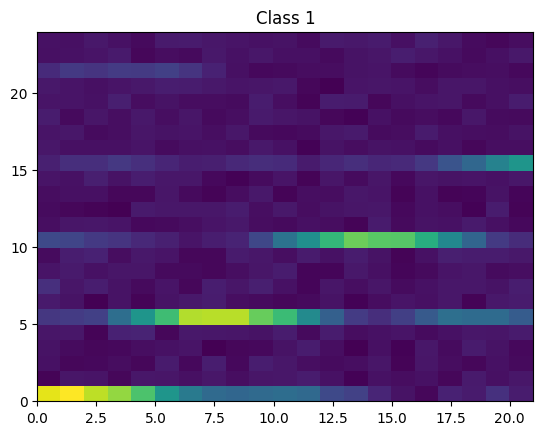

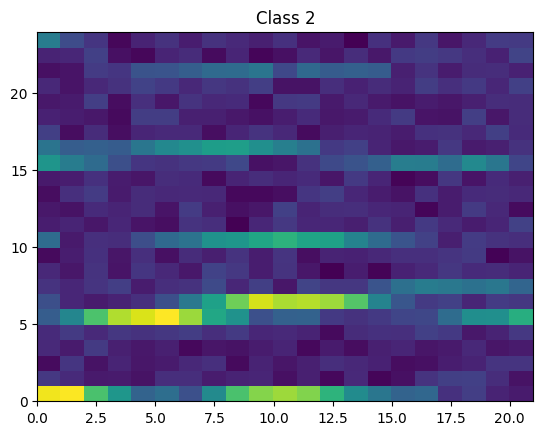

In [16]:
idx = np.random.randint(X_train_arr.shape[1])
plt.figure(facecolor='w')
plt.pcolor(X_train_arr[1][idx])
plt.title("Class 1")

idx = np.random.randint(X_train_arr.shape[1])
plt.figure(facecolor='w')
plt.pcolor(X_train_arr[0][idx])
plt.title("Class 2")

In [13]:
torch.cuda.set_device(device=CUDA_DEVICE)
epochs = 15
valid_batch = 4096
valid_mini_batch = 1024

# Reshape
X_train_arr = X_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, model_index.flatten().shape[0])
Y_train_arr = Y_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, class_num)

X_train_arr, Y_train_arr = shuffle(X_train_arr, Y_train_arr)
model = HPC(X_train_arr.shape[1], Y_train_arr.shape[1]).cuda()
try:
    model(torch.Tensor(X_train_arr[:5]).cuda())
except:
    raise NameError("The input shape should be revised")

total_parameter = sum(p.numel() for p in model.parameters())
print('total_parameter: ', total_parameter / 1000000, 'M')


total_parameter:  2.633218 M


C:\Users\KISTQUANTUM\Desktop\Deep Learning\.venv\Lib\site-packages\torch\nn\init.py:511: UserWarning:

Initializing zero-element tensors is a no-op



In [14]:
torch.cuda.set_device(device=CUDA_DEVICE)
epochs = 15
valid_batch = 4096
valid_mini_batch = 1024

# Reshape
X_train_arr = X_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, model_index.flatten().shape[0])
Y_train_arr = Y_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, class_num)

X_train_arr, Y_train_arr = shuffle(X_train_arr, Y_train_arr)
model = HPC(X_train_arr.shape[1], Y_train_arr.shape[1]).cuda()
try:
    model(torch.Tensor(X_train_arr[:5]).cuda())
except:
    raise NameError("The input shape should be revised")

total_parameter = sum(p.numel() for p in model.parameters())
print('total_parameter: ', total_parameter / 1000000, 'M')


total_parameter:  2.633218 M


C:\Users\KISTQUANTUM\Desktop\Deep Learning\.venv\Lib\site-packages\torch\nn\init.py:511: UserWarning:

Initializing zero-element tensors is a no-op



Text(0.5, 1.0, 'Class 2')

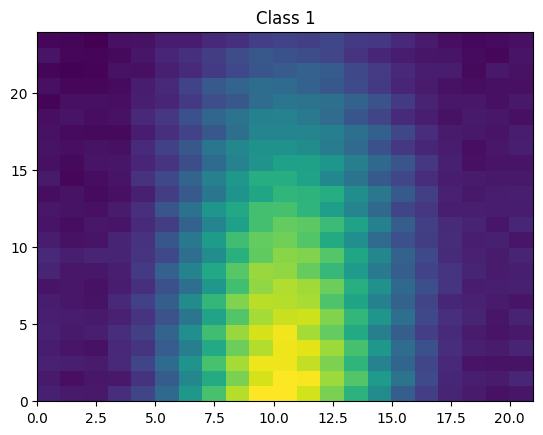

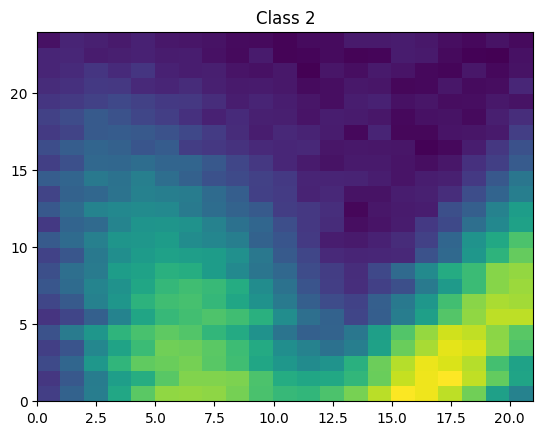

In [11]:
idx = np.random.randint(X_train_arr.shape[1])
plt.figure(facecolor='w')
plt.pcolor(X_train_arr[1][idx])
plt.title("Class 1")

idx = np.random.randint(X_train_arr.shape[1])
plt.figure(facecolor='w')
plt.pcolor(X_train_arr[0][idx])
plt.title("Class 2")

____
For example, if a predicted confidence score is (0.0001, 0.993), then it infers there exist no target spin. And if a confidence score is (0.991, 0.000001), then it suggests that there exist 1 target spin.
___


In [12]:
torch.cuda.set_device(device=CUDA_DEVICE)
epochs = 15
valid_batch = 4096
valid_mini_batch = 1024

# Reshape
X_train_arr = X_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, model_index.flatten().shape[0])
Y_train_arr = Y_train_arr.reshape(class_num*len(AB_idx_set)*class_batch, class_num)

X_train_arr, Y_train_arr = shuffle(X_train_arr, Y_train_arr)
model = HPC(X_train_arr.shape[1], Y_train_arr.shape[1]).cuda()
try:
    model(torch.Tensor(X_train_arr[:5]).cuda())
except:
    raise NameError("The input shape should be revised")

total_parameter = sum(p.numel() for p in model.parameters())
print('total_parameter: ', total_parameter / 1000000, 'M')


total_parameter:  3.66541 M


In [13]:
MODEL_PATH = SAVE_DIR_NAME
if not os.path.exists(MODEL_PATH): os.mkdir(MODEL_PATH)

mini_batch_list = [2048]
learning_rate_list = [5e-6]
op_list = [['Adabound', [30,15,7,1]]]
criterion = nn.BCELoss().cuda()
hyperparameter_set = [[mini_batch, learning_rate, selected_optim_name] for mini_batch, learning_rate, selected_optim_name in itertools.product(mini_batch_list, learning_rate_list, op_list)]
print("==================== A_idx: {}, B_idx: {} ======================".format(A_first, B_first))

total_loss, total_val_loss, total_acc, trained_model = train(MODEL_PATH, N_PULSE, X_train_arr, Y_train_arr, model, hyperparameter_set, criterion,
                                                            epochs, valid_batch, valid_mini_batch)
min_A = np.min(np.array(AB_idx_set)[:,0])
max_A = np.max(np.array(AB_idx_set)[:,0])

model.load_state_dict(torch.load(trained_model[0][0]))
model.eval()
print("Model loaded as evalutation mode. Model path:", trained_model[0][0])

==================== A_idx: 10000, B_idx: 12000 ======================
train_batch:  21504 valid_batch:  4096


 Training Start:  Thu May  8 17:21:16 2025
 mini_batch: 2048  | learning_rate:  5e-06  | selected_optim_name:  ['Adabound', [30, 15, 7, 1]]  |


C:\Users\KISTQUANTUM\Desktop\Deep_Learning_CPMG_Analysis\Deep_Learning_CPMG_Analysis\adabound.py:94: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\python_arg_parser.cpp:1691.)



Epoch:    1  | Loss = 0.22705 | Val_loss: 0.48294 | Accuracy: 92.19 % | time: 2.412(s) | lr:  5e-06
Epoch:    2  | Loss = 0.08246 | Val_loss: 0.26887 | Accuracy: 94.82 % | time: 0.093(s) | lr:  5e-06
Epoch:    3  | Loss = 0.05692 | Val_loss: 0.11188 | Accuracy: 98.34 % | time: 0.099(s) | lr:  5e-06
Epoch:    4  | Loss = 0.05268 | Val_loss: 0.07249 | Accuracy: 98.34 % | time: 0.092(s) | lr:  5e-06
Epoch:    5  | Loss = 0.04881 | Val_loss: 0.05946 | Accuracy: 98.54 % | time: 0.087(s) | lr:  5e-06
Epoch:    6  | Loss = 0.04869 | Val_loss: 0.05386 | Accuracy: 98.44 % | time: 0.086(s) | lr:  5e-06
Epoch:    7  | Loss = 0.04591 | Val_loss: 0.05265 | Accuracy: 98.44 % | time: 0.089(s) | lr:  5e-06
Epoch:    8  | Loss = 0.04541 | Val_loss: 0.04855 | Accuracy: 99.02 % | time: 0.09(s) | lr:  5e-06
Epoch:    9  | Loss = 0.04468 | Val_loss: 0.04632 | Accuracy: 98.83 % | time: 0.088(s) | lr:  5e-06
Epoch:   10  | Loss = 0.04078 | Val_loss: 0.04661 | Accuracy: 98.63 % | time: 0.088(s) | lr:  1.75e-0

____
### If you see the results with 'Accuracy' around 98~99%, then the model is trained enough.  

Text(0.5, 1.0, 'Classification Accuracy (%)')

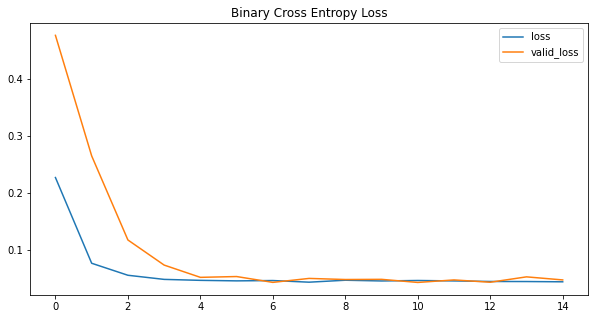

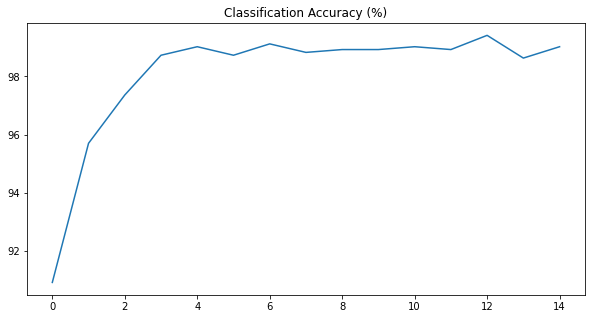

In [ ]:
plt.figure(facecolor='w', figsize=(10, 5))
plt.plot(total_loss, label='loss')
plt.plot(total_val_loss, label='valid_loss')
plt.title('Binary Cross Entropy Loss')
plt.legend()
plt.figure(facecolor='w', figsize=(10, 5))
plt.plot(total_acc)
plt.title('Classification Accuracy (%)')

___
### Let's evaluate the simulated CPMG signal with using the trained model which covers the following range.


Note: The simulated data will be intentionally include (or exclude) a spin in the range below.

========================================================================<br>
A_range:10000 ~ 10200 (Hz)<br>
B_range:12000 ~ 70000 (Hz)<br>
========================================================================<br>

In [14]:
A_index = 10050
target_spin = AB_lists_dic[A_index][500] / 1000
total_spins = np.array([
                        target_spin,
                        [41, 53],
                        [18, 11],
                        [-17, 18],
                        [-23, 15],
                        [-35, 28],
])

Text(0.5, 1.0, 'Test image')

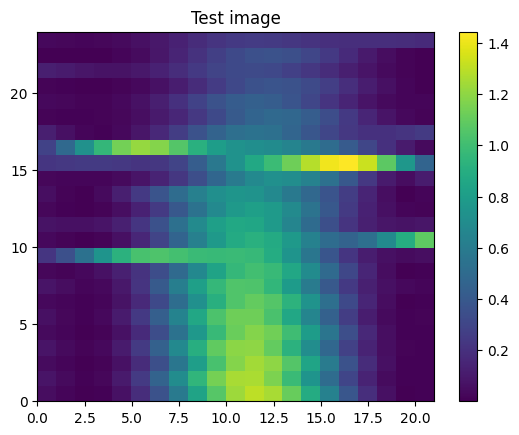

In [15]:
M_values = M_list_return(time_data*1e-6, WL_VALUE, total_spins*2000*np.pi, N_PULSE)
M_modified = 1 - M_values[model_index]
plt.figure(facecolor='w')
plt.pcolor(M_modified)
plt.colorbar()
plt.title('Test image')

____

*   It obviously shows a vertical line at the center, which indicates the signal has a spin with the same period as the target period. <br>
: So, the predicted confidence score should have the highest value in Class 2 dimension.



In [16]:
M_modified_tensor = torch.Tensor(M_modified.flatten()).cuda()
M_modified_tensor = torch.unsqueeze(M_modified_tensor, 0)
model(M_modified_tensor)

tensor([[0.0350, 0.9452]], device='cuda:0', grad_fn=<SigmoidBackward0>)

___
It shows the highest confidence score in 2nd dimension which indicates there is one target spin.

In [17]:
total_spins = np.array([
                        [41, 53],
                        [18, 11],
                        [-17, 18],
                        [-23, 15],
                        [-35, 28],
])

Text(0.5, 1.0, 'Test image')

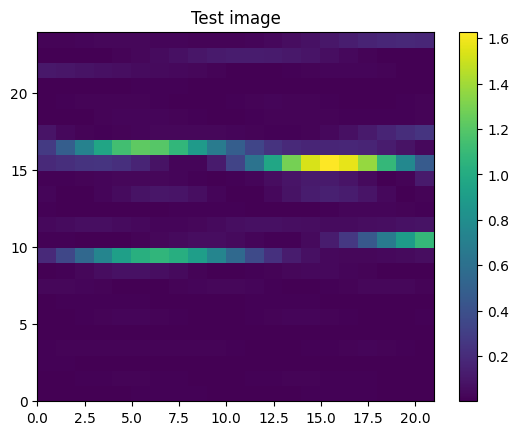

In [18]:
M_values = M_list_return(time_data*1e-6, WL_VALUE, total_spins*2000*np.pi, N_PULSE)
M_modified = 1 - M_values[model_index]
plt.figure(facecolor='w')
plt.pcolor(M_modified)
plt.colorbar()
plt.title('Test image')

In [19]:
M_modified_tensor = torch.Tensor(M_modified.flatten()).cuda()
M_modified_tensor = torch.unsqueeze(M_modified_tensor, 0)
model(M_modified_tensor)

tensor([[0.9906, 0.0060]], device='cuda:0', grad_fn=<SigmoidBackward0>)

___
It shows the highest confidence score in 1st dimension which indicates there is no target spin.